# Finding Outliers in Univariate and Multivariate Time Series

## About this notebook

Notebook prepared by **Jesus Perez Colino**, First Released: 12/03/2019 (work-in-progress)

- This work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. This work is offered for free, with the hope that it will be useful.
- **Summary**: The current notebook search into the statistical field of outliers detection, first, using univariate methods, where we compare the absolute deviation with respect the median (Leys, C., et al. 2013) vs. recursive mean detection, and second, multivariate methods, where we describe the idea of the Local Outlier Factor (Breunig, M. et al. 2000 ). 
- **References**: 

> Leys, C., et al., *Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median*, Journal of Experimental Social Psychology (2013) <br>

> Breunig, M. M., Kriegel, H. P., Ng, R. T., and Sander, J. *LOF: identifying density-based local outliers* Proc. ACM SIGMOD 2000 Int. Conf. On Management of Data, Dallas, TX (2000, May)<br>

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from pylab import rcParams
rcParams['figure.figsize'] = 20, 4
from sys import version 
print (' Outliers Detection: Conditions for Replication '.center(100,"-"))
print ('Python version:     ' + version )
print ('Numpy version:      ' + np.__version__)
print ('Pandas version:     ' + pd.__version__)
print ('IPython version:    ' + IPython.__version__)
print ('-'*100)

-------------------------- Outliers Detection: Conditions for Replication --------------------------
Python version:     3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
Numpy version:      1.14.0
Pandas version:     0.22.0
IPython version:    6.2.1
----------------------------------------------------------------------------------------------------


## A first view of the data set

In [2]:
file_path = r"C:\Users\admin\Downloads\data.csv"
raw_df = pd.read_csv(file_path)
raw_df = raw_df.transpose()
monthly_index = [str(raw_df.index[i][4:] 
                     +'-'
                     + raw_df.index[i][:4]) for i in range(1,len(raw_df.index))]
name_columns = [raw_df.iloc[0,i] for i in range(len(raw_df.columns))]
df = pd.DataFrame(raw_df.values[1:],
                  index = pd.to_datetime(monthly_index), 
                  columns = name_columns)

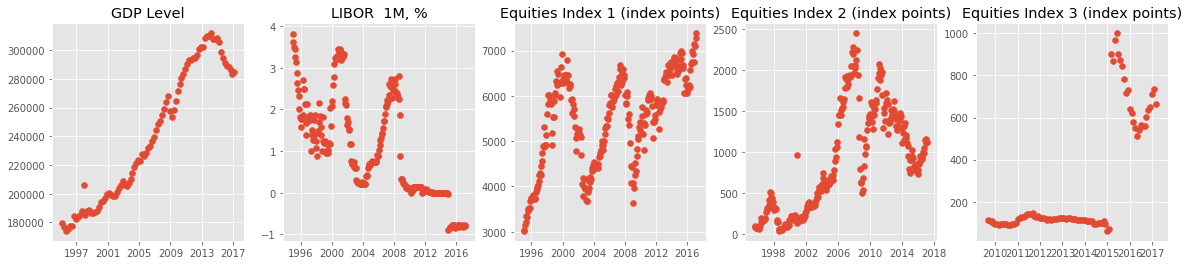

In [3]:
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(ncols=len(df.columns), nrows=1)
    for i in range(len(df.columns)):
        axes[i].scatter(df.index, df.iloc[:,i])
        axes[i].set_title(df.columns[i])

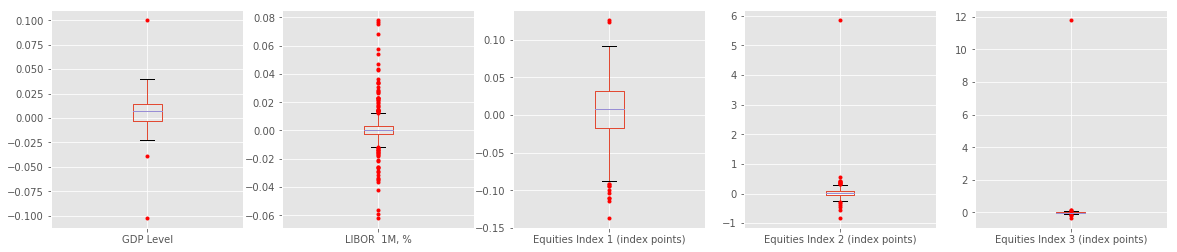

In [10]:
def data_change(data, tao=30/360):
    for i in range(len(df.columns)):
        if data.name[:5]=='LIBOR':
            price_FRA = 1/(1+data*tao) # Brigo & Mercurio (1.9)
            return price_FRA.pct_change().replace([np.inf, -np.inf], np.nan)
        else:
            return data.pct_change().replace([np.inf, -np.inf], np.nan)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(1,5)
    for i in range(len(df.columns)):
        df_pct_change = data_change(df.iloc[:,i]).dropna()           
        df_pct_change.plot.box(ax=ax[i], sym='r.')

## Univariate methods for Outliers detection

Here below, we will compare two methods, the first one based in the traditional outlier selection using a gaussian measure, using as criteria the *mean plus/minus three standard deviations* (in the single and in a recursive way), and we compare it with the **Leys, C., et al. (2013)** method based in the *median absolute deviation*.

In [5]:
def outliers_by_median_deviation(data, b = 0.6745, threshold = 3.5):
    '''Based in Leys, C., et al., Detecting outliers: 
    Do not use standard deviation around the mean, use absolute deviation around the median, 
    Journal of Experimental Social Psychology (2013)'''
    from collections import OrderedDict
    if isinstance(data, pd.core.frame.DataFrame) == False:
        return print('Wrong data type. Only pandas dataframes')
    def data_change(data, tao = 30/360):
        if data.name[:5]=='LIBOR':
            price_FRA = 1/(1+data*tao)
            return price_FRA.pct_change().replace([np.inf, -np.inf], np.nan)
        else:
            return data.pct_change().replace([np.inf, -np.inf], np.nan)
    outliers = OrderedDict()
    for i in range(len(data.columns)):
        data_pct_change = data_change(data.iloc[:,i]).dropna()
        median = data_pct_change.median()
        median_abs_deviation = (data_pct_change - median).abs().median()
        modified_z_score = b * (data_pct_change - median) / median_abs_deviation
        outliers[data.columns[i]] = data_pct_change[modified_z_score > threshold]
    return pd.DataFrame(outliers)

In [6]:
def outliers_by_std(data, num_std = 3):
    from collections import OrderedDict
    if isinstance(data, pd.core.frame.DataFrame) == False:
        return print('Wrong data type. Only pandas dataframes')
    def data_change(data, tao = 30/360):
        if data.name[:5]=='LIBOR':
            price_FRA = 1/(1 + data * tao)
            return price_FRA.pct_change().replace([np.inf, -np.inf], np.nan)
        else:
            return data.pct_change().replace([np.inf, -np.inf], np.nan)
    
    outliers=OrderedDict()
    for i in range(len(data.columns)):
        data_pct_change = data_change(data.iloc[:,i]).dropna()
        outliers[data.columns[i]] = data_pct_change[((data_pct_change - 
                                                      data_pct_change.mean()).abs()
                                                     >(num_std * data_pct_change.std()))]
    return pd.DataFrame(outliers)


In [7]:
def recursive_outliers_by_std(data, num_outliers = 0, num_std = 3, ):
    from collections import OrderedDict
    if isinstance(data, pd.core.frame.DataFrame) == False:
        return print('Wrong data type. Only pandas dataframes')
    outliers_recursive = outliers_by_std(data, num_std)
    num_outliers_new = num_outliers + len(outliers_recursive)
    data_clean = OrderedDict()
    if len(outliers_recursive)>3:
        for i in range(len(data.columns)):
            clean_column = data.iloc[:,i].dropna().replace(data.iloc[:,i].loc[outliers_recursive
                                                                  .iloc[:,i].index].values, np.nan)
            data_clean[data.columns[i]] = clean_column.astype(float).interpolate(method='time')
        return recursive_outliers_by_std(pd.DataFrame(data_clean), num_outliers = num_outliers_new)
    else:
        return data, num_outliers_new


In [8]:
print(f'Outliers detedted by outliers_by_std: {len(outliers_by_std(df))}')
print(f'Outliers detedted by recursive_outliers_by_std: {recursive_outliers_by_std(df)[1]}')
print(f'Outliers detedted by outliers_by_median_deviation: {len(outliers_by_median_deviation(df))}')

Outliers detedted by outliers_by_std: 14
Outliers detedted by recursive_outliers_by_std: 42
Outliers detedted by outliers_by_median_deviation: 33


In [9]:
%%timeit
outliers_by_std(df)

12.5 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
recursive_outliers_by_std(df)

110 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
outliers_by_median_deviation(df)

13.5 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


According with the previous results, looks clear that using a recursive procedure based in 3-std is computationally quite demanding, and probably,mathematically, not well-founded.

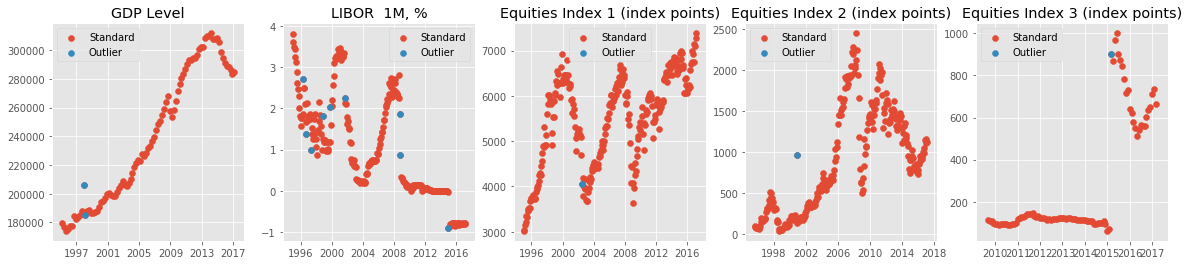

In [12]:
with plt.style.context(('ggplot')):
    outliers = outliers_by_std(df)
    fig, axes = plt.subplots(ncols=len(df.columns), nrows=1)
    for i in range(len(df.columns)):
        axes[i].scatter(df.index, df.iloc[:,i], label='Standard')
        axes[i].scatter(outliers.iloc[:,i].dropna().index, 
                        df.iloc[:,i].loc[outliers.iloc[:,i].dropna().index],
                       label='Outlier')
        axes[i].set_title(df.columns[i])
        axes[i].legend()

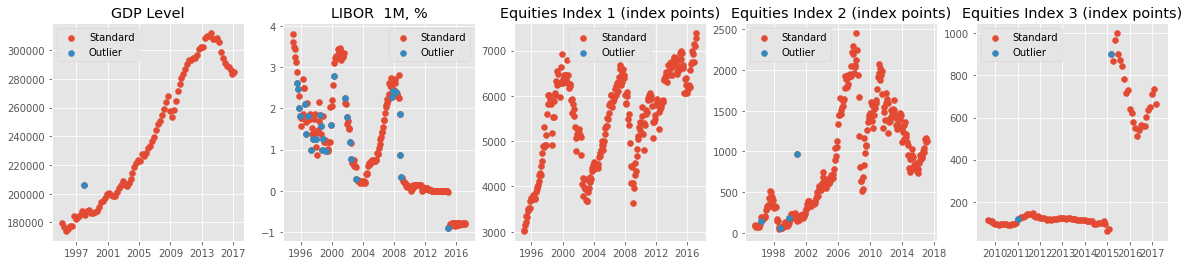

In [13]:
del outliers
with plt.style.context(('ggplot')):
    outliers = outliers_by_median_deviation(df)
    fig, axes = plt.subplots(ncols=len(df.columns), nrows=1)
    for i in range(len(df.columns)):
        axes[i].scatter(df.index, df.iloc[:,i], label='Standard')
        axes[i].scatter(outliers.iloc[:,i].dropna().index, 
                        df.iloc[:,i].loc[outliers.iloc[:,i].dropna().index],
                       label = 'Outlier')
        axes[i].set_title(df.columns[i])
        axes[i].legend()

**References: **

> Leys, C., et al., *Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median*, Journal of Experimental Social Psychology (2013)

## Multivariate methods for Outliers detection

In [14]:
# Re-loading original data to avoid possible overwritten variables

file_path = r"C:\Users\admin\Downloads\data.csv"
raw_df = pd.read_csv(file_path)
raw_df = raw_df.transpose()
monthly_index = [str(raw_df.index[i][4:] 
                     +'-'
                     + raw_df.index[i][:4]) for i in range(1,len(raw_df.index))]
name_columns = [raw_df.iloc[0,i] for i in range(len(raw_df.columns))]
df = pd.DataFrame(raw_df.values[1:],
                  index = pd.to_datetime(monthly_index), 
                  columns = name_columns)

In [15]:
# Importing some auxiliary functions for the latter LOF calculation

from heapq import nsmallest
from sklearn.metrics.pairwise import pairwise_distances
from collections import defaultdict

In [16]:
# Defining some auxiliary funtions 

def minkowsky_distance(a, b, p=2):
    'Multi-dimensional minkowski distance between points a and b'
    return np.power(np.sum((np.power((x1 - x2), p)) for x1, x2 in zip(a, b)), 1/p)

def normalized_df(data):
    if isinstance(data, pd.core.frame.DataFrame) == False:
        return print('Wrong data type. Only pandas dataframes')
    return (data-data.mean())/df.std()

def minmax_normalized_df(data):
    if isinstance(data, pd.core.frame.DataFrame) == False:
        return print('Wrong data type. Only pandas dataframes')
    return (data-data.min())/(data.max()-data.min())

In [17]:
# Normalizing data and filling GDP at monthly scale interpolating, scaled with time

df_normalized = normalized_df(df.astype(float).interpolate(method='time').dropna())
dist = pairwise_distances(df_normalized)

Following **Breunig et al. (2000)** (see references at the end of this notebook), the idea of the **Local Outlier Factor**, or LOF, works by calculating the *local density of each point*. Based on the distance of k-nearest neighbors of a point, the local density of the point is estimated. By comparing the local density of the point with the densities of its neighbors, outliers are detected. Outliers have a low density compared with their neighbors.

We will need to go through some term definitions in order to understand LOF:

- The **k-distance of object P** is the distance between the object P and its k-th nearest neighbor. K is a parameter of the algorithm (20 in our case).

In [18]:
def k_distance(data, dist, k=20):
    '''Calculate K distance'''
    if isinstance(data, pd.core.frame.DataFrame) == False:
        return print('Wrong data type. Only pandas dataframes')
    k_distance = defaultdict(tuple)
    for i in range(data.shape[0]):
        distances = dist[i].tolist()
        ksmallest = nsmallest(k+1,distances)[1:][k-1]
        ksmallest_idx = distances.index(ksmallest)
        # For each data point store the K th nearest neighbour and its distance
        k_distance[i]=(ksmallest,ksmallest_idx)
    return k_distance

In [19]:
k_distance_l = k_distance(df_normalized, dist)

In [20]:
def all_indices(value, inlist):
    out_indices = []
    idx = -1
    while True:
        try:
            idx = inlist.index(value, idx+1)
            out_indices.append(idx)
        except ValueError:
            break
    return out_indices

- The **k-distance neighborhood of P** is the list of all the objects, Q, whose distance from P is either less than or equal to the distance between P and its kth nearest object.


In [23]:
def k_distance_neig(data, dist, k_distance, k=20):
    '''Calculate K distance neighbourhood'''
    k_distance_neig = defaultdict(list)
    # For each data point
    for i in range(data.shape[0]):
        distances = dist[i].tolist()
        # Get the 1 to K nearest neighbours
        ksmallest = nsmallest(k+1,distances)[1:]
        ksmallest_set = set(ksmallest)
        ksmallest_idx = []
        for x in ksmallest_set:
            ksmallest_idx.append(all_indices(x,distances))
        # flattening a list of list to list
        ksmallest_idx = [item for sublist in ksmallest_idx for item in sublist]
        # For each data point, store the K distance neighbourhood
        k_distance_neig[i].extend(zip(ksmallest,ksmallest_idx))
    return k_distance_neig

In [24]:
k_distance_neig_l = k_distance_neig(df_normalized, dist, k_distance_l)

- The **reachability distance** from P to Q is defined as the *maximum of the distance between P and its kth nearest neighbor, and the distance between P and Q*. 
- The **Local Reachability Density** of P (LRD(P)) is the *ratio of the k-distance neighborhood of P and the sum of the reachability distance of k and its neighborhood*.

In [25]:
def local_reach_density(data, k_distance_neig, k_distance, k=20):
    '''Calculate the Local reachable density'''
    local_reach_density = defaultdict(float)
    for i in range(data.shape[0]):
        # LRDs numerator, number of K distance neighbourhood
        no_neighbours = len(k_distance_neig[i])
        denom_sum = 0
        # Reachability distance sum
        for neigh in k_distance_neig[i]:
            # maximum(K-Distance(P), Distance(P,Q))
            denom_sum += max(k_distance[neigh[1]][0],neigh[0])
        local_reach_density[i] = no_neighbours/(1.0*denom_sum)
    return local_reach_density

In [26]:
local_reach_density_l = local_reach_density(df_normalized, k_distance_neig_l, k_distance_l)

- The **Local Outlier Factor** of P (LOF(P)) is the *average of the ratio of the local reachability of P and those of P's k-nearest neighbors*.

In [27]:
def lof_list(data, k_distance, k_distance_neig, local_reach_density):
    '''Calculate Local Outlier Factor (LOF)'''
    lof_list =[]
    for i in range(data.shape[0]):
        lrd_sum = 0
        rdist_sum = 0
        for neigh in k_distance_neig[i]:
            lrd_sum += local_reach_density[neigh[1]]
            rdist_sum += max(k_distance[neigh[1]][0],neigh[0])
        lof_list.append((i,lrd_sum*rdist_sum))
    return lof_list

In [28]:
lof_list_l =lof_list(df_normalized, k_distance_l, k_distance_neig_l, local_reach_density_l)

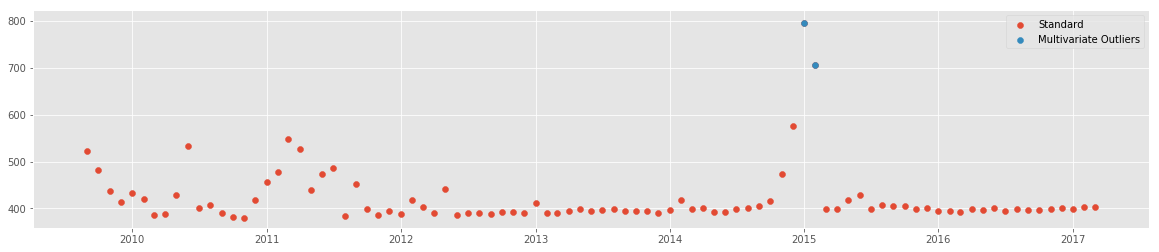

In [29]:
df_lof_list = pd.DataFrame([lof_list_l[i][1] for i in range(len(lof_list_l))],
                          index=[lof_list_l[i][0] for i in range(len(lof_list_l))])

with plt.style.context(('ggplot')): 
    plt.scatter(df_normalized.index, df_lof_list, label='Standard')
    plt.scatter(df_normalized.index, 
                df_lof_list[(df_lof_list-df_lof_list.mean()).abs()>3*df_lof_list.std()], 
                label='Multivariate Outliers')
    plt.legend()

**References:**


>Breunig, M. M., Kriegel, H. P., Ng, R. T., and Sander, J. *LOF: identifying density-based local outliers* Proc. ACM SIGMOD 2000 Int. Conf. On Management of Data, Dallas, TX (2000, May).